In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
from pandas.io.json import json_normalize
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

In [28]:
# This function allows us to flatten out the columns in the pandas dataframe which are in the json format

def load_df(csv_path='../input/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']):
    print('Loading csv...')
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, # list of functions for each column namely json.loads 
                     dtype={'fullVisitorId': 'str','totals':'str', 'trafficSource':'str'})
    
    for column in JSON_COLUMNS:
        print(column)
        column_as_df = json_normalize(df[column].tolist())
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

def column_type(dataFrame):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:[] for object_type in type_keys }
    
    for column in dataFrame.columns:
        Dict[dataFrame[column].dtype].append(column)
    
    return Dict


def column_counts(dataFrame, threshold):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:{} for object_type in type_keys}
    
    for column in dataFrame.columns:
        
        if len(dataFrame[column].unique()) <= threshold:
            
            Dict[dataFrame[column].dtype][column] = len(dataFrame[column].unique())
            
    return Dict



def date_time_conversion(dataFrame, column, year = 0, month = 0, day = 0, weekday = 0, unit = None ,errors = None , format = None):
    
    dataFrame[column] = pd.to_datetime(dataFrame[column], format = format, errors = errors, unit = unit)
    
    if year: 
        dataFrame[column+'_year'] = dataFrame[column].apply(lambda x: x.year)
    
    if month:
        dataFrame[column+'_month'] = dataFrame[column].apply(lambda x: x.month)
        
    if day:
        dataFrame[column+'_day'] = dataFrame[column].apply(lambda x: x.day)
        
    if weekday:
        dataFrame[column+'_weekday'] = dataFrame[column].apply(lambda x: x.weekday())
    
    return dataFrame
        
    
    

In [29]:
def NaN_value_count(dataFrame):
    for column in dataFrame.columns:
        print('column name:'+str(column))
        print('number of NaN values: '+str(dataFrame[column].isnull().sum() ))
        print('percentage of NaN values: '+str(dataFrame[column].isnull().sum()/dataFrame.shape[0] ))
        print('------------')

        
def count_distribution(dataFrame,column):
    column_count = pd.Series.to_frame(dataFrame.groupby(column).size(),'count')
    column_count.reset_index(inplace = True)
    total = column_count['count'].sum()
    column_count['proportion'] = column_count['count']/total
    return column_count


def conditional_frequency_encode(dataFrame, grouped_col, predictor,binarised_col):
    dataFrame_summarise = dataFrame.groupby(grouped_col).agg({grouped_col:{grouped_col+'_count':np.size},
                                                              predictor:{predictor+'_sum':np.sum, predictor+'_avg':np.mean, predictor+'_var':np.std},
                                                              binarised_col:{binarised_col+'_sum':np.sum}})
    dataFrame_summarise.reset_index(inplace = True)
    dataFrame_summarise.columns = dataFrame_summarise.columns.droplevel(0)
    dataFrame_summarise.fillna(0, inplace=True)
    
    dataFrame_summarise[grouped_col+'_probability'] = dataFrame_summarise[grouped_col+'_count']/dataFrame_summarise[grouped_col+'_count'].sum()
    
    
    dataFrame_summarise[binarised_col+'_conditional_probability'] = dataFrame_summarise[binarised_col+'_sum']/dataFrame_summarise[grouped_col+'_count']
    
    return dataFrame_summarise

In [4]:
train = pd.read_csv('/Users/psangha/Desktop/Kaggle/Kaggle-Google-Analytics-Customer-Revenue/data/train_flattened.csv')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


## Preprocessing 

In [33]:
train["totals.transactionRevenue"].fillna(0, inplace=True)

In [34]:
date_time_conversion(train, column = 'date', year = 1, month = 1, day = 1, weekday = 1, unit = None, errors = 'ignore', format = '%Y%m%d')

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,date_year,date_month,date_day,date_weekday
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,...,NaN,NaN,google + online,organic,NaN,google,2016,9,2,4
4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,...,NaN,True,(not provided),organic,NaN,google,2016,9,2,4
5,5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,1472807194,1,1472807194,Chrome,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
6,6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,1472817241,1,1472817241,Chrome,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
7,7,Organic Search,2016-09-02,537222803633850821,537222803633850821_1472812602,1472812602,1,1472812602,Chrome,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
8,8,Organic Search,2016-09-02,4445454811831400414,4445454811831400414_1472805784,1472805784,1,1472805784,Internet Explorer,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
9,9,Organic Search,2016-09-02,9499785259412240342,9499785259412240342_1472812272,1472812272,1,1472812272,Firefox,desktop,...,NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4


In [35]:
date_time_conversion(train,column='visitStartTime', year = 1, month = 1, day = 1, weekday = 1,unit='s',errors='ignore')

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.referralPath,trafficSource.source,date_year,date_month,date_day,date_weekday,visitStartTime_year,visitStartTime_month,visitStartTime_day,visitStartTime_weekday
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,...,NaN,google,2016,9,2,4,2016,9,3,5
2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,...,NaN,google,2016,9,2,4,2016,9,3,5
3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,...,NaN,google,2016,9,2,4,2016,9,3,5
4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,...,NaN,google,2016,9,2,4,2016,9,2,4
5,5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,1472807194,1,2016-09-02 09:06:34,Chrome,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4
6,6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,1472817241,1,2016-09-02 11:54:01,Chrome,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4
7,7,Organic Search,2016-09-02,537222803633850821,537222803633850821_1472812602,1472812602,1,2016-09-02 10:36:42,Chrome,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4
8,8,Organic Search,2016-09-02,4445454811831400414,4445454811831400414_1472805784,1472805784,1,2016-09-02 08:43:04,Internet Explorer,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4
9,9,Organic Search,2016-09-02,9499785259412240342,9499785259412240342_1472812272,1472812272,1,2016-09-02 10:31:12,Firefox,desktop,...,NaN,google,2016,9,2,4,2016,9,2,4


In [36]:
# Lets create a variable which one-hot-encodes whether a transaction value is 0 or not
transaction_series = train['totals.transactionRevenue'] 
train['is_transaction'] = transaction_series.apply(lambda x:1 if x>0 else 0)

In [37]:
train.shape

(903653, 46)

In [38]:
# Types of columns that have a total number of unique values less than a threshold
# note if we set threshold = 1 we are looking for constant columns. 

constant_column_dict = column_counts(train, threshold = 1)
constant_column_dict

{dtype('int64'): {},
 dtype('O'): {},
 dtype('<M8[ns]'): {},
 dtype('bool'): {},
 dtype('float64'): {}}

In [39]:
keys = list(constant_column_dict.keys())
constant_columns = []
for type_key in keys:
    for column_key in list(constant_column_dict[type_key].keys()):
        constant_columns.append(column_key)

train = train.drop(constant_columns, axis = 1)

In [40]:
train.shape

(903653, 46)

In [41]:
train.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.sourc

## Analysis

In [42]:
column_counts(train,4)

{dtype('int64'): {'date_year': 2,
  'visitStartTime_year': 2,
  'is_transaction': 2},
 dtype('O'): {'device.deviceCategory': 3,
  'trafficSource.adwordsClickInfo.adNetworkType': 3,
  'trafficSource.adwordsClickInfo.isVideoAd': 2,
  'trafficSource.adwordsClickInfo.slot': 3,
  'trafficSource.campaignCode': 2,
  'trafficSource.isTrueDirect': 2},
 dtype('<M8[ns]'): {},
 dtype('bool'): {'device.isMobile': 2},
 dtype('float64'): {'totals.bounces': 2, 'totals.newVisits': 2}}

In [63]:
# The binary columns are the following

# We do not include date_year, visitStartTime_year and is_transaction

binary_columns = ['trafficSource.adwordsClickInfo.isVideoAd','trafficSource.campaignCode','trafficSource.isTrueDirect',
                  'device.isMobile','totals.bounces', 'totals.newVisits']

tertiary_columns = ['device.deviceCategory','trafficSource.adwordsClickInfo.adNetworkType',
                    'trafficSource.adwordsClickInfo.slot']


remaining_columns = [column for column in train.columns if column not in binary_columns and column not in tertiary_columns]
remaining_columns

['Unnamed: 0',
 'channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'date_year',
 'date_month',
 'date_day',
 'date_weekday',
 'visitStartTime_year',
 'visitStartTime_month',
 'visitStartTime_day',
 'visitStartTime_weekday',
 'is_transaction']

In [64]:
columns_to_be_removed = ['fullVisitorId','sessionId','visitId','date','date_year','visitStartTime_year']
for columns in columns_to_be_removed:
    print(columns)
    remaining_columns.remove(columns)


fullVisitorId
sessionId
visitId
date
date_year
visitStartTime_year


In [65]:
remaining_columns

['Unnamed: 0',
 'channelGrouping',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'date_month',
 'date_day',
 'date_weekday',
 'visitStartTime_month',
 'visitStartTime_day',
 'visitStartTime_weekday',
 'is_transaction']

In [66]:
train.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.source,date_year,date_month,date_day,date_weekday,visitStartTime_year,visitStartTime_month,visitStartTime_day,visitStartTime_weekday,is_transaction
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,...,google,2016,9,2,4,2016,9,2,4,0
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,...,google,2016,9,2,4,2016,9,3,5,0
2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,...,google,2016,9,2,4,2016,9,3,5,0
3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,...,google,2016,9,2,4,2016,9,3,5,0
4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,...,google,2016,9,2,4,2016,9,2,4,0


In [84]:
encoding_list = []

### Device browser

In [77]:
device_browser_summary = conditional_frequency_encode(train,'device.browser','totals.transactionRevenue','is_transaction')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


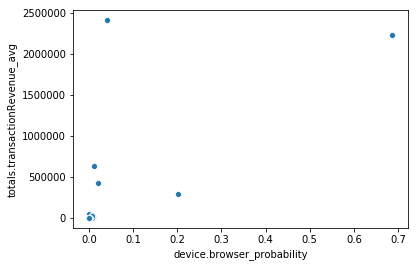

In [78]:
x = device_browser_summary['device.browser_probability']
y = device_browser_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

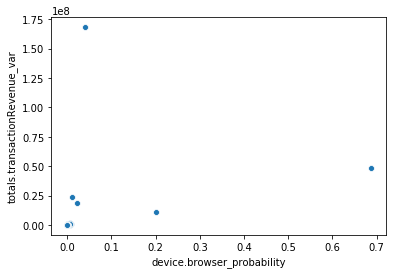

In [79]:
x = device_browser_summary['device.browser_probability']
y = device_browser_summary['totals.transactionRevenue_var']
sns.scatterplot(x,y)

In [8]:
train_device_browser = train['device.browser'].value_counts().to_frame()
train_device_browser.
#train_device_browser['device.browser_probability'] = train['device.browser']/train['device.browser'].sum()
#train_device_browser

Index(['device.browser'], dtype='object')

In [85]:
### Add to encoding list 

encoding_list.append('device.browser')

In [18]:
device_browser['device_browser_count'] = device_browser.groupby('device.browser')['device.browser'].transform('count')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
device_browser

,device.browser,totals.transactionRevenue,device_browser_count
0,Chrome,0.0,620364
1,Firefox,0.0,37069
2,Chrome,0.0,620364
3,UC Browser,0.0,2427
4,Chrome,0.0,620364
5,Chrome,0.0,620364
6,Chrome,0.0,620364
7,Chrome,0.0,620364
8,Internet Explorer,0.0,19375
9,Firefox,0.0,37069


### Device operating system 

In [83]:
### Device operating system 

device_operating_system_summary = conditional_frequency_encode(train,'device.operatingSystem','totals.transactionRevenue','is_transaction')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


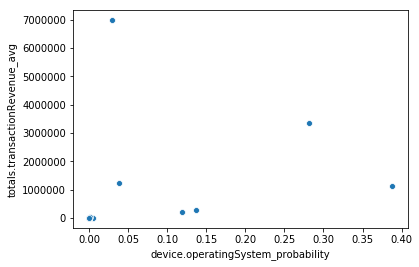

In [87]:
x = device_operating_system_summary['device.operatingSystem_probability']
y = device_operating_system_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

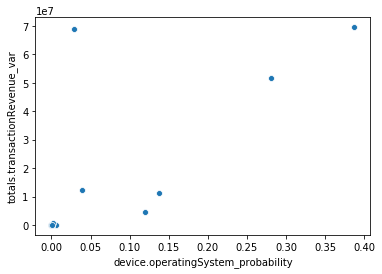

In [88]:
x = device_operating_system_summary['device.operatingSystem_probability']
y = device_operating_system_summary['totals.transactionRevenue_var']
sns.scatterplot(x,y)

In [89]:
encoding_list.append('device.operatingSystem')

### geoNetwork city 



In [92]:
geoNetwork_city_summary = conditional_frequency_encode(train,'geoNetwork.city','totals.transactionRevenue','is_transaction')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


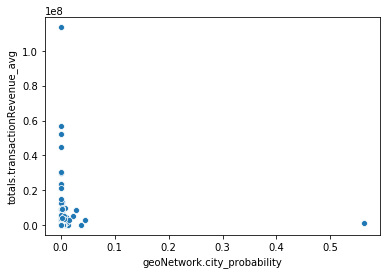

In [93]:
x = geoNetwork_city_summary['geoNetwork.city_probability']
y = geoNetwork_city_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

In [ ]:
### Do not encode city

### geoNetwork continent

In [96]:
geoNetwork_continent_summary = conditional_frequency_encode(train,'geoNetwork.continent','totals.transactionRevenue','is_transaction')
geoNetwork_continent_summary

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,geoNetwork.continent_count,totals.transactionRevenue_sum,totals.transactionRevenue_avg,totals.transactionRevenue_var,is_transaction_sum,geoNetwork.continent_probability,is_transaction_conditional_probability
0,(not set),1468,7.697800e+08,5.243733e+05,1.022584e+07,6,0.001625,0.004087
1,Africa,14745,8.687760e+09,5.892004e+05,3.172588e+07,8,0.016317,0.000543
2,Americas,450377,1.504672e+12,3.340916e+06,7.421233e+07,11283,0.498396,0.025052
3,Asia,223698,1.740184e+10,7.779167e+04,8.782713e+06,125,0.247549,0.000559
4,Europe,198311,6.747030e+09,3.402247e+04,2.790665e+06,79,0.219455,0.000398
5,Oceania,15054,1.793230e+09,1.191198e+05,6.131133e+06,14,0.016659,0.000930


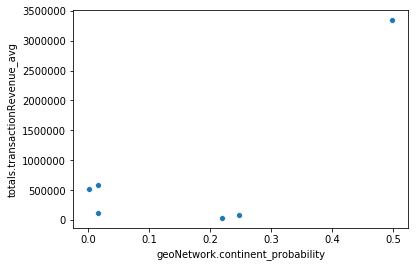

In [95]:
x = geoNetwork_continent_summary['geoNetwork.continent_probability']
y = geoNetwork_continent_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

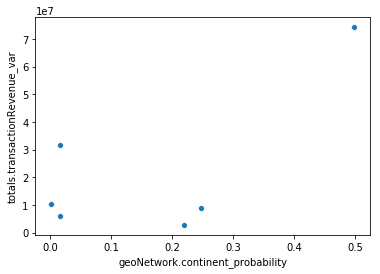

In [97]:
x = geoNetwork_continent_summary['geoNetwork.continent_probability']
y = geoNetwork_continent_summary['totals.transactionRevenue_var']
sns.scatterplot(x,y)

In [99]:
encoding_list.append('geoNetwork.continent')

### geoNetwork country

In [100]:
geoNetwork_country_summary = conditional_frequency_encode(train,'geoNetwork.country','totals.transactionRevenue','is_transaction')
geoNetwork_country_summary

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,geoNetwork.country_count,totals.transactionRevenue_sum,totals.transactionRevenue_avg,totals.transactionRevenue_var,is_transaction_sum,geoNetwork.country_probability,is_transaction_conditional_probability
0,(not set),1468,7.697800e+08,5.243733e+05,1.022584e+07,6,0.001625,0.004087
1,Afghanistan,57,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000063,0.000000
2,Albania,547,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000605,0.000000
3,Algeria,2055,0.000000e+00,0.000000e+00,0.000000e+00,0,0.002274,0.000000
4,American Samoa,1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000001,0.000000
5,Andorra,17,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000019,0.000000
6,Angola,58,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000064,0.000000
7,Anguilla,1,1.099000e+07,1.099000e+07,0.000000e+00,1,0.000001,1.000000
8,Antigua & Barbuda,5,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000006,0.000000
9,Argentina,5037,2.624400e+08,5.210244e+04,1.956556e+06,5,0.005574,0.000993


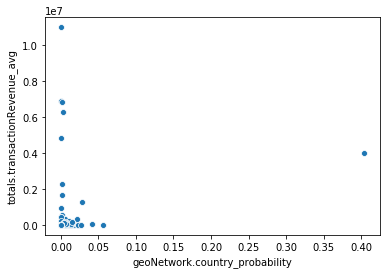

In [101]:
x = geoNetwork_country_summary['geoNetwork.country_probability']
y = geoNetwork_country_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

In [102]:
### Do Not add country to encoding

### geoNetwork metro

In [103]:
geoNetwork_metro_summary = conditional_frequency_encode(train,'geoNetwork.metro','totals.transactionRevenue','is_transaction')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


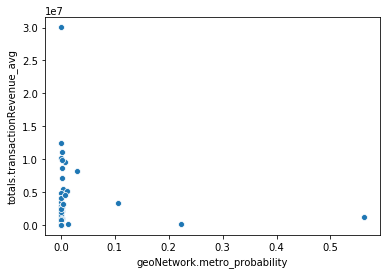

In [105]:
x = geoNetwork_metro_summary['geoNetwork.metro_probability']
y = geoNetwork_metro_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

### geoNetwork network domain

In [108]:
geoNetwork_network_summary = conditional_frequency_encode(train,'geoNetwork.networkDomain','totals.transactionRevenue','is_transaction')
geoNetwork_network_summary

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,geoNetwork.networkDomain_count,totals.transactionRevenue_sum,totals.transactionRevenue_avg,totals.transactionRevenue_var,is_transaction_sum,geoNetwork.networkDomain_probability,is_transaction_conditional_probability
0,(not set),244881,8.482641e+11,3.463985e+06,4.916977e+07,6645,0.270990,0.027136
1,0101.net.au,4,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000004,0.000000
2,012.net.il,312,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000345,0.000000
3,018.net.il,103,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000114,0.000000
4,02.net,517,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000572,0.000000
5,04.4-x64,1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000001,0.000000
6,099.net.il,15,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000017,0.000000
7,0beta,1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000001,0.000000
8,0pb.org,1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000001,0.000000
9,0rbitel.net,10,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000011,0.000000


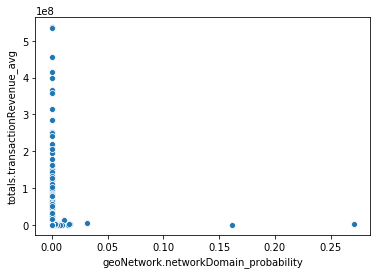

In [107]:
x = geoNetwork_network_summary['geoNetwork.networkDomain_probability']
y = geoNetwork_network_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

In [109]:
remaining_columns

['Unnamed: 0',
 'channelGrouping',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'date_month',
 'date_day',
 'date_weekday',
 'visitStartTime_month',
 'visitStartTime_day',
 'visitStartTime_weekday',
 'is_transaction']

### geoNetwork.subContinent

In [111]:
geoNetwork_continent_summary = conditional_frequency_encode(train,'geoNetwork.subContinent','totals.transactionRevenue','is_transaction')

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


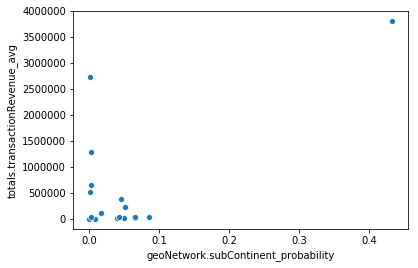

In [113]:
x = geoNetwork_continent_summary['geoNetwork.subContinent_probability']
y = geoNetwork_continent_summary['totals.transactionRevenue_avg']
sns.scatterplot(x,y)

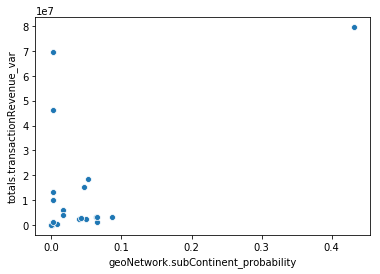

In [114]:
x = geoNetwork_continent_summary['geoNetwork.subContinent_probability']
y = geoNetwork_continent_summary['totals.transactionRevenue_var']
sns.scatterplot(x,y)

In [115]:
encoding_list.append('geoNetwork.subContinent')